In [75]:
import pandas as pd
import numpy as np
import os
from collections import Counter, defaultdict
import sys
import matplotlib.pyplot as plt
import regex as re

CONST_A = 0
CONST_C = 1
CONST_G = 2
CONST_T = 3

CONST_NT_MAP = ['A', 'C', 'G', 'T']

def reverse_complement(seq) :
    rc_seq = ''
    for i in range(0, len(seq)) :
        if seq[i] == 'A' :
            rc_seq = 'T' + rc_seq
        elif seq[i] == 'C' :
            rc_seq = 'G' + rc_seq
        elif seq[i] == 'G' :
            rc_seq = 'C' + rc_seq
        elif seq[i] == 'T' :
            rc_seq = 'A' + rc_seq
    return rc_seq

def key_shifted_sequence(seq, i) :
    seq_i = seq[i:] + seq[0:i]
    return seq_i

def hamming_cluster_library(sequences, counts, total_counts, hamming_thresh=4) :
    seq_len = len(sequences[0])
    
    print('Removing hamming neighbors on dimension:')
    for i in range(seq_len) :
        sequences = sorted(sequences, key=lambda x: key_shifted_sequence(x, i))
        
        sequences, counts = hamming_cluster_round(sequences, counts, total_counts, hamming_thresh)
        print(i)
    return sequences, counts

def hamming_cluster_round(seqs, counts, total_counts, hamming_thresh) :
    removed_set = {}
    
    i = 0
    j = 1
    while j < len(seqs) :
        
        if distance(seqs[i], seqs[j]) < hamming_thresh:
            
            if total_counts[seqs[i]] >= total_counts[seqs[j]] :
                removed_set[seqs[j]] = True
                for k in range(len(counts)) :
                    counts[k][seqs[i]] += counts[k][seqs[j]]
                
                j += 1
            else :
                removed_set[seqs[i]] = True
                for k in range(len(counts)) :
                    counts[k][seqs[j]] += counts[k][seqs[i]]
                
                i = j
                j += 1
                
        else :
            i = j
            j += 1
    
    hamming_seqs = []
    for seq in seqs :
        if seq not in removed_set :
            hamming_seqs.append(seq)
    return hamming_seqs, counts

def distance(astring, bstring) :
    distance = 0
    
    limit = len(astring)
    diff = len(bstring) - len(astring)
    if len(bstring) < len(astring) :
        limit = len(bstring)
        diff = len(astring) - len(bstring)
    
    for i in range(limit) :
        if astring[i] != bstring[i] :
            distance += 1
    return distance + diff

def is_misprimed(seq, read, start_pos) :
    
    if start_pos >= len(seq) - 10 :
        return False
    
    a_count = 0
    
    if seq[start_pos - 1] == 'A' :
        a_count += 1
    #if seq[start_pos - 1] == 'A' and seq[start_pos - 2] == 'A' :
    #    a_count += 1
    
    #if distance(seq[start_pos-10:start_pos], read[-10:]) > 4 :
    #    return True
    
    for i in range(0, 10) :
        if seq[start_pos + i] == 'A' :
            a_count += 1
        
        if i < 4 and a_count >= 3 :
            return True
        if i < 7 and a_count >= 4 :
            return True
        elif i < 8 and a_count >= 5 :
            return True
        elif i < 9 and a_count >= 6 :
            return True
    return False


#Make Valid PAS lookup hierarchy

cano_pas1 = 'AATAAA'
cano_pas2 = 'ATTAAA'

valid_pas = []

valid_pas.append({})
valid_pas[0]['AATAAA'] = True

valid_pas.append({})
valid_pas[1]['ATTAAA'] = True

valid_pas.append({})
valid_pas[2]['AGTAAA'] = True
valid_pas[2]['TATAAA'] = True
valid_pas[2]['CATAAA'] = True
valid_pas[2]['GATAAA'] = True

valid_pas.append({})
for pos in range(0, 6) :
    for base in ['C', 'G', 'T'] :
        valid_pas[3][cano_pas1[:pos] + base + cano_pas1[pos+1:]] = True

valid_pas[3]['AATTAA'] = False

valid_pas.append({})
valid_pas[4]['AGGAAA'] = True
valid_pas[4]['ACCAAA'] = True
valid_pas[4]['AACAAA'] = True
valid_pas[4]['AAGAAA'] = True
valid_pas[4]['TACAAA'] = True
valid_pas[4]['TAGAAA'] = True
valid_pas[4]['ATTATA'] = True
valid_pas[4]['ATTACA'] = True
valid_pas[4]['ATTAGA'] = True

def has_upstream_pas(seq, start_pos, pas_limit=[3, 40]) :
    if start_pos >= 191 :
        return True
    
    for i_end in range(start_pos - pas_limit[0], start_pos - pas_limit[1], -1) :
        i_start = i_end - 6
        
        for k in range(0, len(valid_pas)) :
            if seq[i_start:i_end] in valid_pas[k] and valid_pas[k][seq[i_start:i_end]] == True :
                return True
    return False

In [60]:
dna_file = pd.read_csv('../doubledope_dna_hamming2_antimisprime.csv',sep=',')

dna_barcode_list = list(dna_file.barcode)
dna_sequence_list = list(dna_file.sequence)

dna_barcode_map = {}
dna_sequence_map = {}
dna_identity_map = {}

misprime_regexes = [
    re.compile(r"(AAAAAAA)")
]

print(len(dna_barcode_list))

for i in range(0, len(dna_barcode_list)) :
    misprime_suspect = False
    for misprime_regex in misprime_regexes :
        if re.search(misprime_regex, dna_sequence_list[i]) :
            misprime_suspect = True
    
    if not misprime_suspect :
        dna_barcode_map[dna_barcode_list[i]] = dna_barcode_list[i]
        dna_sequence_map[dna_barcode_list[i]] = dna_sequence_list[i]
        dna_identity_map[dna_barcode_list[i]] = i

print(len(dna_barcode_map))

2123419
2123419


In [61]:
#Generate UMI maps

mer6_map = {}

bases = 'ACGT'#'ACGTN'
i = 0
for base1 in bases:
    for base2 in bases:
        for base3 in bases:
            for base4 in bases:
                for base5 in bases:
                    for base6 in bases:
                        umi = base1 + base2 + base3 + base4 + base5 + base6
                        mer6_map[umi] = i
                        i += 1

print(len(mer6_map))

4096


In [69]:

rna_file = open('doubledope_rna_mapped_hammingsearch1_all_with_barcode.csv', 'r')
count = 0

mapped_proximal_count = {}
mapped_distal_count = {}
mapped_umi_map = {}

total_valid_aligns = 0
total_unique_umi_count = 0

#proximal1_limits = [56, 70]
#proximal2_limits = [140, 154]
#distal_limits = [304, 324]

print('Mapping RNA reads to DNA members.')


rna_file.readline()

i = 0

for line_raw in rna_file :
    line = line_raw.rstrip()
    
    i += 1
    if line == None or len(line) == 0 :
        break
    
    lineparts = line.split(',')
    if len(lineparts) != 9 :
        break
    
    barcode = lineparts[0]
    umi = lineparts[1]
    read = lineparts[2]
    
    ref_start = int(lineparts[3])
    ref_end = int(lineparts[4])
    read_start = int(lineparts[5])
    read_end = int(lineparts[6])
    
    polya_pos = int(lineparts[7]) - 30 #Subtract mapped constant region from alignment
    align_score = float(lineparts[8])
    
    if barcode not in dna_sequence_map :
        continue
    
    seq = barcode + dna_sequence_map[barcode]
    
    if 'N' in umi :
        continue
    
    if seq not in mapped_proximal_count :
        mapped_proximal_count[seq] = []
        mapped_distal_count[seq] = []
    
    if align_score >= 60 and has_upstream_pas(seq, polya_pos + 1, pas_limit=[3, 40]) and not is_misprimed(seq, read, polya_pos + 1) :
        total_valid_aligns += 1
        
        if dna_identity_map[barcode] not in mapped_umi_map :
            mapped_umi_map[dna_identity_map[barcode]] = {}
        
        is_dup_umi = False

        if mer6_map[umi] in mapped_umi_map[dna_identity_map[barcode]] :
            is_dup_umi = True
        
        if is_dup_umi == False :
            total_unique_umi_count += 1
            mapped_umi_map[dna_identity_map[barcode]][mer6_map[umi]] = True
            
            if polya_pos + 1 < 191 :
                mapped_proximal_count[seq].append(polya_pos + 1)
            elif polya_pos + 1 >= 300 :
                mapped_distal_count[seq].append(polya_pos + 1 - 300)
    
    if count % 1000000 == 0 :
        print(count)
        print(str(total_valid_aligns) + ' valid read align count')
        print(str(total_unique_umi_count) + ' unique umi count')
        print(str(len(mapped_proximal_count)) + ' mapped unique library members')
    count += 1
    
print('COMPLETE')
print(str(total_valid_aligns) + ' valid read align count')
print(str(total_unique_umi_count) + ' unique umi count')
print(str(len(mapped_proximal_count)) + ' mapped unique library members')

rna_file.close()

mapped_seq_list = []
mapped_proximal_count_list = []
mapped_distal_count_list = []
mapped_total_proximal_count_list = []
mapped_total_distal_count_list = []
mapped_total_count_list = []

for seq in mapped_proximal_count :
    if len(mapped_proximal_count[seq]) > 0 or len(mapped_distal_count[seq]) > 0 :
        mapped_seq_list.append(seq)
        mapped_proximal_count_list.append(str(mapped_proximal_count[seq]))
        mapped_distal_count_list.append(str(mapped_distal_count[seq]))
        mapped_total_proximal_count_list.append(len(mapped_proximal_count[seq]))
        mapped_total_distal_count_list.append(len(mapped_distal_count[seq]))
        mapped_total_count_list.append(len(mapped_proximal_count[seq]) + len(mapped_distal_count[seq]))

print(str(len(mapped_seq_list)) + ' kept library members')

df = pd.DataFrame({'sequence'  : mapped_seq_list,
                   'proximal_cuts' : mapped_proximal_count_list,
                   'distal_cuts' : mapped_distal_count_list,
                   'proximal_count' : mapped_total_proximal_count_list,
                   'distal_count' : mapped_total_distal_count_list,
                   'total_count' : mapped_total_count_list})

df = df.sort_values('total_count').reset_index(drop=True)

print(len(df))

new_columns = ['sequence', 'proximal_cuts', 'distal_cuts', 'proximal_count', 'distal_count', 'total_count']
df.to_csv('doubledope_library_hamming2_dna_antimisprime_rna_antimisprime_score_60.csv', sep=',', header=True, columns=new_columns, index=False)

Mapping RNA reads to DNA members.
0
0 valid read align count
0 unique umi count
1 mapped unique library members
1000000
169659 valid read align count
168624 unique umi count
489406 mapped unique library members
2000000
408999 valid read align count
406000 unique umi count
758777 mapped unique library members
3000000
651663 valid read align count
646437 unique umi count
950851 mapped unique library members
4000000
855844 valid read align count
848517 unique umi count
1102189 mapped unique library members
5000000
1054340 valid read align count
1044936 unique umi count
1208031 mapped unique library members
6000000
1304227 valid read align count
1291884 unique umi count
1308141 mapped unique library members
7000000
1560438 valid read align count
1544628 unique umi count
1392760 mapped unique library members
8000000
1744569 valid read align count
1726496 unique umi count
1462390 mapped unique library members
9000000
1972184 valid read align count
1950905 unique umi count
1518981 mapped uniq

80000000
17096401 valid read align count
16411631 unique umi count
2076727 mapped unique library members
81000000
17318934 valid read align count
16618655 unique umi count
2077519 mapped unique library members
82000000
17511577 valid read align count
16796554 unique umi count
2078305 mapped unique library members
83000000
17723183 valid read align count
16992003 unique umi count
2079060 mapped unique library members
COMPLETE
17904793 valid read align count
17157476 unique umi count
2079601 mapped unique library members
1962272 kept library members
1962272


In [70]:

df_filename = 'doubledope_library_hamming2_dna_antimisprime_rna_antimisprime_score_60'

df = pd.read_csv(df_filename + '.csv', delimiter=',')
print(len(df))

#df = df[df.total_count >= 10].reset_index(drop=True)
#print(len(df))

1962272


In [71]:

import scipy.sparse as sp

prox_cuts = sp.lil_matrix((len(df), 191))
dist_cuts = sp.lil_matrix((len(df), 100))

i = 0
for index, row in df.iterrows() :
    if index % 100000 == 0 :
        print('Processing cuts for index = ' + str(i))
    
    prox_list = []
    
    if len(row['proximal_cuts']) > 2 and ',' not in row['proximal_cuts'] :
        prox_list = [row['proximal_cuts'][1:-1]]
    elif len(row['proximal_cuts']) > 2 :
        prox_list = row['proximal_cuts'][1:-1].split(', ')
    
    dist_list = []
    
    if len(row['distal_cuts']) > 2 and ',' not in row['distal_cuts'] :
        dist_list = [row['distal_cuts'][1:-1]]
    elif len(row['distal_cuts']) > 2 :
        dist_list = row['distal_cuts'][1:-1].split(', ')
    
    for prox_pos_str in prox_list :
        prox_cuts[index, int(prox_pos_str)] += 1
    for dist_pos_str in dist_list :
        dist_cuts[index, int(dist_pos_str)] += 1

    i += 1

prox_cuts = sp.csr_matrix(prox_cuts)
dist_cuts = sp.csr_matrix(dist_cuts)

Processing cuts for index = 0
Processing cuts for index = 100000
Processing cuts for index = 200000
Processing cuts for index = 300000
Processing cuts for index = 400000
Processing cuts for index = 500000
Processing cuts for index = 600000
Processing cuts for index = 700000
Processing cuts for index = 800000
Processing cuts for index = 900000
Processing cuts for index = 1000000
Processing cuts for index = 1100000
Processing cuts for index = 1200000
Processing cuts for index = 1300000
Processing cuts for index = 1400000
Processing cuts for index = 1500000
Processing cuts for index = 1600000
Processing cuts for index = 1700000
Processing cuts for index = 1800000
Processing cuts for index = 1900000


In [72]:
import scipy.io as spio

spio.savemat(df_filename + '_cuts', {'proximal' : prox_cuts, 'distal' : dist_cuts})


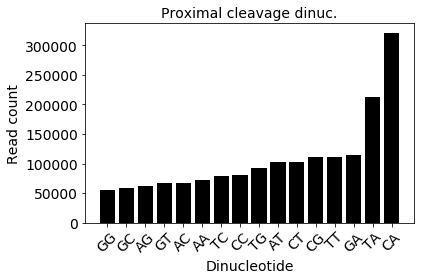

In [73]:
import operator

cut_mer2 = {}

seqs = list(df['sequence'].values)
seqs = np.array(seqs, dtype=np.object)

cx = sp.coo_matrix(prox_cuts)

for i,j,v in zip(cx.row, cx.col, cx.data) :
    seq = seqs[i]
    
    mer2 = seq[j-1:j+1]
    if mer2 not in cut_mer2 :
        cut_mer2[mer2] = 0
    cut_mer2[mer2] += 1

cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

mer2_list = []
mer2_vals = []
for i in range(0, len(cut_mer2_sorted)) :
    mer2_list.append(cut_mer2_sorted[i][0])
    mer2_vals.append(cut_mer2_sorted[i][1])

f = plt.figure(figsize=(6, 4))

plt.bar(mer2_list, mer2_vals, color='black')

plt.title('Proximal cleavage dinuc.', fontsize=14)
plt.xlabel('Dinucleotide', fontsize=14)
plt.ylabel('Read count', fontsize=14)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

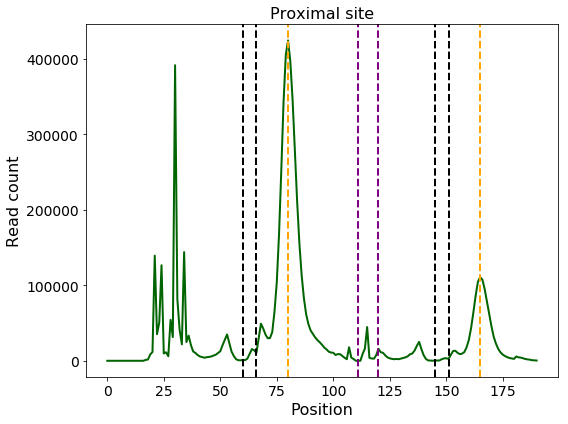

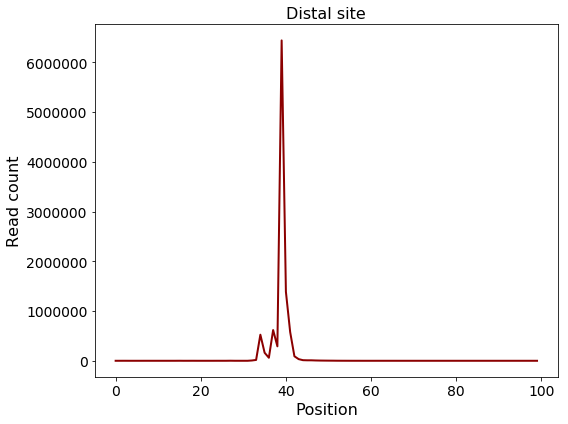

In [74]:

proximal_profile = np.ravel(prox_cuts.sum(axis=0))
distal_profile = np.ravel(dist_cuts.sum(axis=0))

figure_suffix = '_with_dna_antimisprime'

f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(proximal_profile)), proximal_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=60, linewidth=2, c='black', linestyle='--')
plt.axvline(x=60 + 6, linewidth=2, c='black', linestyle='--')

#plt.axvline(x=56, linewidth=2, c='green', linestyle='--')
plt.axvline(x=60 + 20, linewidth=2, c='orange', linestyle='--')
#plt.axvline(x=70, linewidth=2, c='green', linestyle='--')

#Proximal 2
plt.axvline(x=145, linewidth=2, c='black', linestyle='--')
plt.axvline(x=145 + 6, linewidth=2, c='black', linestyle='--')

#plt.axvline(x=140, linewidth=2, c='green', linestyle='--')
plt.axvline(x=145 + 20, linewidth=2, c='orange', linestyle='--')
#plt.axvline(x=154, linewidth=2, c='green', linestyle='--')


plt.axvline(x=111, linewidth=2, c='purple', linestyle='--')
plt.axvline(x=120, linewidth=2, c='purple', linestyle='--')


#plt.axvline(x=21, linewidth=2, c='red', linestyle='--')
#plt.axvline(x=24, linewidth=2, c='red', linestyle='--')
#plt.axvline(x=30, linewidth=2, c='red', linestyle='--')
#plt.axvline(x=34, linewidth=2, c='red', linestyle='--')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

#plt.savefig('doubledope_proximal_cut_profile' + figure_suffix + '.png')
plt.show()


f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(distal_profile)), distal_profile, c='darkred', linewidth=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Distal site', fontsize=16)
plt.tight_layout()

#plt.savefig('doubledope_distal_cut_profile' + figure_suffix + '.png')
plt.show()


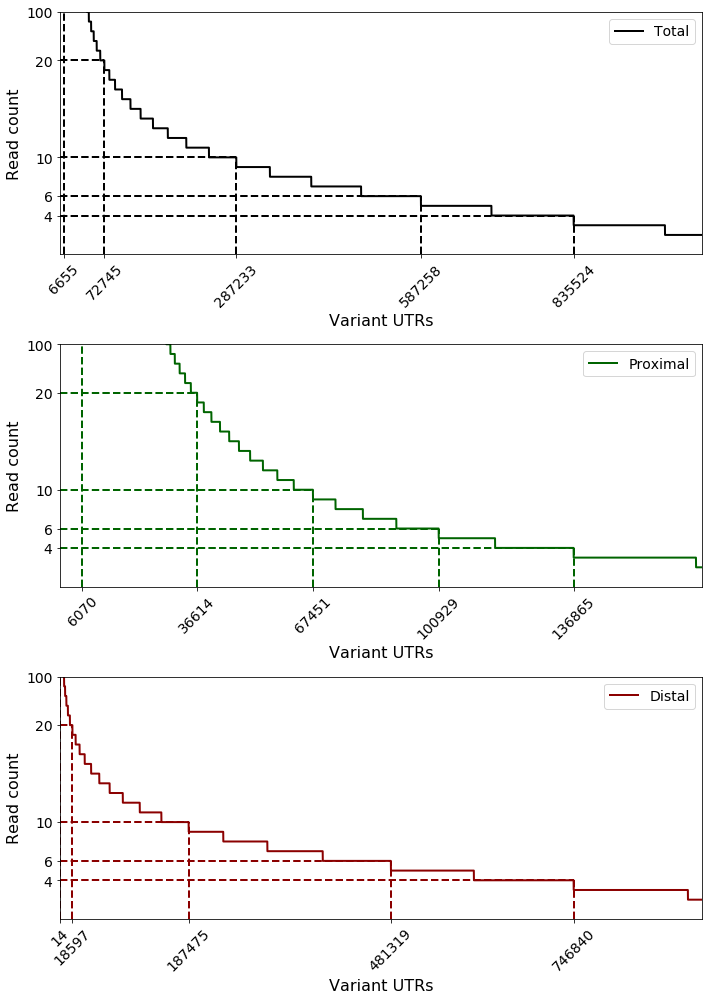

In [200]:
min_count = 1

proximal_count = np.ravel(prox_cuts.sum(axis=1))
distal_count = np.ravel(dist_cuts.sum(axis=1))
total_count = proximal_count + distal_count

filter_index = np.nonzero(total_count >= min_count)[0]

proximal_count = proximal_count[filter_index]
distal_count = distal_count[filter_index]
total_count = total_count[filter_index]
n_events = filter_index.shape[0]

sort_index_prox = np.argsort(proximal_count)[::-1]
sort_index_dist = np.argsort(distal_count)[::-1]
sort_index_total = np.argsort(total_count)[::-1]

#f = plt.figure(figsize=(12, 6))

count_list = [
    total_count,
    proximal_count,
    distal_count
]

sort_index_list = [
    sort_index_total,
    sort_index_prox,
    sort_index_dist
]

color_list = [
    'black',
    'darkgreen',
    'darkred'
]

site_list = [
    'Total',
    'Proximal',
    'Distal'
]


fig, ax = plt.subplots(3, 1, figsize=(10, 14))

read_count_marks = [4, 6, 10, 20, 100]

for i in range(0, len(count_list)) :
    ls = []

    li, = ax[i].plot(np.arange(n_events), count_list[i][sort_index_list[i]], c=color_list[i], linewidth=2, label=site_list[i])
    ls.append(li)

    #Avg marks
    l_mark_coords = []
    for read_count_mark in read_count_marks :
        n_marked_events = np.sum(count_list[i] >= read_count_mark) - 1
        l_mark_coords.append(n_marked_events)
        l_markx, = ax[i].plot([n_marked_events, n_marked_events], [0, count_list[i][sort_index_list[i]][n_marked_events]], color=color_list[i], linestyle='--', linewidth=2)#, label='RC >= ' + str(read_count_mark)
        l_marky, = ax[i].plot([0, n_marked_events], [count_list[i][sort_index_list[i]][n_marked_events], count_list[i][sort_index_list[i]][n_marked_events]], color=color_list[i], linestyle='--', linewidth=2)

        #ls.append(l_mark)

    ax[i].set_xlabel('Variant UTRs', fontsize=16)
    ax[i].set_ylabel('Read count', fontsize=16)
    
    ax[i].set_xticks(l_mark_coords)
    #ax[i].set_yticks(read_count_marks)
    ax[i].set_yticks(read_count_marks[:-1] + [read_count_marks[-2] * 1.25])
    ax[i].set_yticklabels(read_count_marks)

    ax[i].tick_params(axis='x', which='major', labelsize=14, rotation=45)
    ax[i].tick_params(axis='x', which='minor', labelsize=14, rotation=45)
    
    ax[i].tick_params(axis='y', which='major', labelsize=14, rotation=0)
    ax[i].tick_params(axis='y', which='minor', labelsize=14, rotation=0)
    
    #ax[i].set_ylim(0, read_count_marks[-1] * 1.25)
    #ax[i].set_xlim(0, n_events)

    ax[i].set_ylim(0, read_count_marks[-2] * 1.25)
    ax[i].set_xlim(0, l_mark_coords[0] * 1.25)
    
    ax[i].legend(handles=ls, fontsize=14)

plt.tight_layout()
plt.savefig('doubledope_readcount_distribution.png')
plt.show()

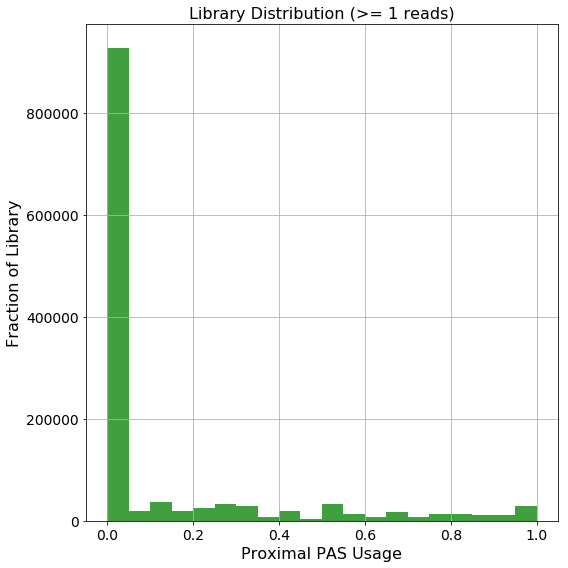

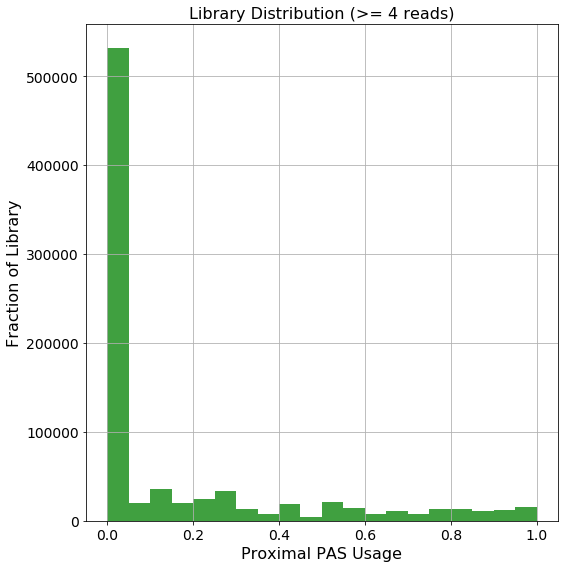

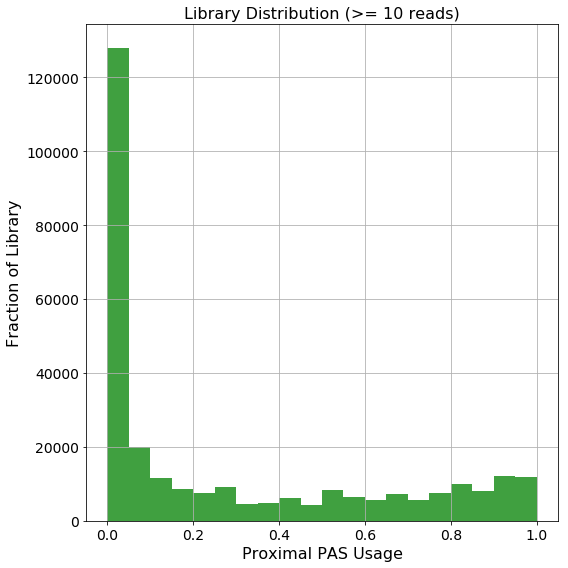

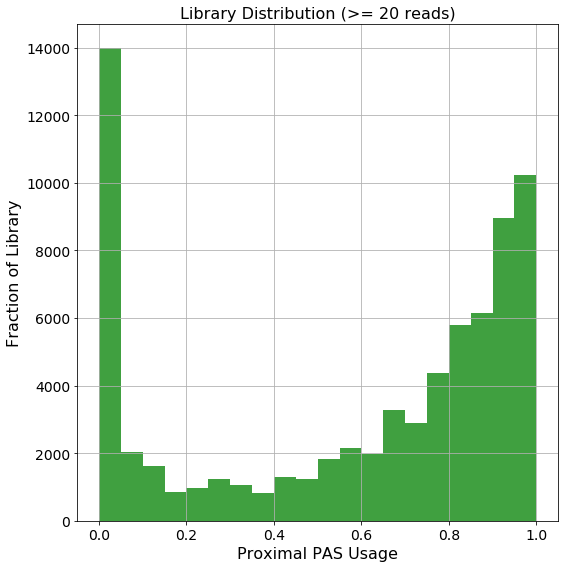

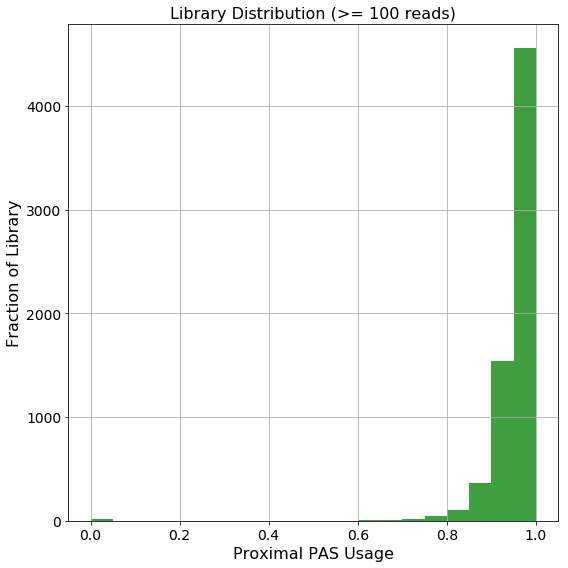

In [208]:
min_counts = [1, 4, 10, 20, 100]

for min_count in min_counts :
    proximal_count = np.ravel(prox_cuts.sum(axis=1))
    distal_count = np.ravel(dist_cuts.sum(axis=1))
    total_count = proximal_count + distal_count

    filter_index = np.nonzero(total_count >= min_count)[0]

    proximal_count = proximal_count[filter_index]
    distal_count = distal_count[filter_index]
    total_count = total_count[filter_index]
    n_events = filter_index.shape[0]

    prox_ratio = proximal_count / total_count

    f = plt.figure(figsize=(8, 8))

    n, bins, patches = plt.hist(prox_ratio, 20, density=False, facecolor='green', alpha=0.75)

    # add a 'best fit' line

    plt.title('Library Distribution (>= ' + str(min_count) + ' reads)', fontsize = 16)
    plt.xlabel('Proximal PAS Usage', fontsize=16)
    plt.ylabel('Fraction of Library', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.grid(True)

    plt.tight_layout()
    plt.show()